# Simulating the NBA 3-Point Contest

The goal of this simulation is to use real data about the NBA players' 3-point percentages to simulate the NBA's [2025 Starry 3-Point contest](https://www.nba.com/news/2025-3-point-contest). The simulation will follow the [rules of the contest](docs/2024-Starry-3-Point-Contest-Rules.pdf). The result of each shot in the simulation will be displayed in an animated visualisation.

The NBA data used throughout this notebook is obtained from [NBA Stats](https://www.nba.com/stats) through the [`nba_api`](https://pypi.org/project/nba_api/), a Python module that provides a simple interface for accessing various NBA statistics and data.

<p align="center">
    <img src="animation_contest.gif" alt="3-Point Contest Simulation">
</p>


## Imports

- The [`random`](https://docs.python.org/3/library/random.html) module will help determine whether a shot in the simulation is made (or missed). This will be done by generating a random number between 0 and 1 for each shot attempt and comparing it to the player's shooting percentage from that position. If the random number is less than or equal to the shooting percentage, the shot is considered made; otherwise, it is missed.

- The [`matplotlib.animation`](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) module will be used to animate visualisations of the 3-point contest simulation.

- The [`matplotlib.pyplot`](https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html) module will be used to create figures on which to plot the visualisations and animations.

- The [`mplbasketball`](https://github.com/mlsedigital/mplbasketball) module's [`Court`](https://github.com/mlsedigital/mplbasketball/blob/main/mplbasketball/court.py) class will be used to draw the basketball court on the plots, providing a visual context for the shot attempts.

- The [`nba_api`](https://pypi.org/project/nba_api/)'s [`ShotChartDetail`](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md) class can provide detailed shooting information, such as the shot location or shot result (make or miss). This information will be used to model the players' shooting efficiency from each position in the 3-point contest. The data obtained from this endpoint looks like [this](https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints_output/shotchartdetail_output.md).

- The [`seaborn`](seaborn) module will be used to visualise the categorisation of the basketball court zones.

In [1]:
# Standard library imports
import random

# Related third party imports
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mplbasketball import Court
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import seaborn as sns

## Data Exploration
This section explores the data obtained from the `ShotChartDetail` endpoint. It includes checking the structure and content of the dataset, examining shot locations and results, and identifying shots from the "Starry shot" distance.

In [2]:
# Example of ShotChartDetail
# Get all 3-point attempts in the 2024-25 NBA regular season before the All-Star break
scd = ShotChartDetail(
    team_id=0,
    player_id=0,
    context_measure_simple='FG3A',
    season_type_all_star='Regular Season',
    season_segment_nullable='Pre All-Star',
    season_nullable='2024-25'
)

# Turn data into tabular format and display the first five rows
df = scd.get_data_frames()[0]
df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022400001,7,1642258,Zaccharie Risacher,1610612737,Atlanta Hawks,1,11,43,...,Left Side Center(LC),24+ ft.,26,-168,205,1,0,20241112,BOS,ATL
1,Shot Chart Detail,0022400001,12,1628401,Derrick White,1610612738,Boston Celtics,1,11,24,...,Left Side Center(LC),24+ ft.,28,-181,218,1,0,20241112,BOS,ATL
2,Shot Chart Detail,0022400001,21,1630552,Jalen Johnson,1610612737,Atlanta Hawks,1,10,50,...,Right Side Center(RC),24+ ft.,25,157,203,1,1,20241112,BOS,ATL
3,Shot Chart Detail,0022400001,23,1627759,Jaylen Brown,1610612738,Boston Celtics,1,10,35,...,Right Side Center(RC),24+ ft.,27,102,253,1,1,20241112,BOS,ATL
4,Shot Chart Detail,0022400001,31,1627759,Jaylen Brown,1610612738,Boston Celtics,1,10,6,...,Left Side(L),24+ ft.,24,-228,85,1,0,20241112,BOS,ATL


In [3]:
# Information about each column in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60970 entries, 0 to 60969
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   GRID_TYPE            60970 non-null  object
 1   GAME_ID              60970 non-null  object
 2   GAME_EVENT_ID        60970 non-null  int64 
 3   PLAYER_ID            60970 non-null  int64 
 4   PLAYER_NAME          60970 non-null  object
 5   TEAM_ID              60970 non-null  int64 
 6   TEAM_NAME            60970 non-null  object
 7   PERIOD               60970 non-null  int64 
 8   MINUTES_REMAINING    60970 non-null  int64 
 9   SECONDS_REMAINING    60970 non-null  int64 
 10  EVENT_TYPE           60970 non-null  object
 11  ACTION_TYPE          60970 non-null  object
 12  SHOT_TYPE            60970 non-null  object
 13  SHOT_ZONE_BASIC      60970 non-null  object
 14  SHOT_ZONE_AREA       60970 non-null  object
 15  SHOT_ZONE_RANGE      60970 non-null  object
 16  SHOT

In [4]:
# Check how shot locations are categorised (SHOT_ZONE_...)
df[['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA']].value_counts()

SHOT_ZONE_BASIC    SHOT_ZONE_AREA       
Above the Break 3  Left Side Center(LC)     17598
                   Right Side Center(RC)    16257
                   Center(C)                11287
Left Corner 3      Left Side(L)              7953
Right Corner 3     Right Side(R)             7499
Backcourt          Back Court(BC)             350
Above the Break 3  Back Court(BC)              23
Mid-Range          Right Side(R)                2
                   Left Side(L)                 1
Name: count, dtype: int64

In [5]:
# Check range of coordinates
df[['LOC_X', 'LOC_Y']].describe()

,LOC_X,LOC_Y
count,60970.00000,60970.000000
mean,-5.92352,169.956175
std,169.06560,99.828480
min,-250.00000,-43.000000
25%,-169.00000,83.000000
50%,-10.50000,205.000000
75%,158.00000,245.000000
max,250.00000,842.000000


The X and Y coordinates are given in inches. X ranges from -250 to 250, whereas Y ranges from -43 to 842. If we placed ourselves facing the basket, the NBA coordinate system works like this.
- X decreases towards the left corner of the baseline
- X increases towards the right corner of the baseline
- Y decreases as you get closer to the baseline
- Y increases as you get further away from the baseline

The NBA provides their data using left handed coordinate systems (LHCS), whereas `mplbasketball` uses a right-handed coordinate system (RHCS) for the court drawing. To make the NBA data compatible with the court drawing, it is necessary to flip the y-coordinates of the NBA shot data. 

In [6]:
# Concatenate shot location info into one column
df['SHOT_POSITION'] = df['SHOT_ZONE_BASIC'] + ' - ' + df['SHOT_ZONE_AREA']

# Convert NBA data coordinates to match mplbasketball court drawing
df['LOC_X'] /= 12                   # Inches to feet
df['LOC_Y'] /= 12                   # Inches to feet
df['LOC_X'] *= 1.2                  # Adapt x and y coordinates to plot
df['LOC_Y'] = -df['LOC_Y'] + 39     # Flip the Y-axis to match the vertical "vu" court

The plot below shows how the different shot zones are categorised.

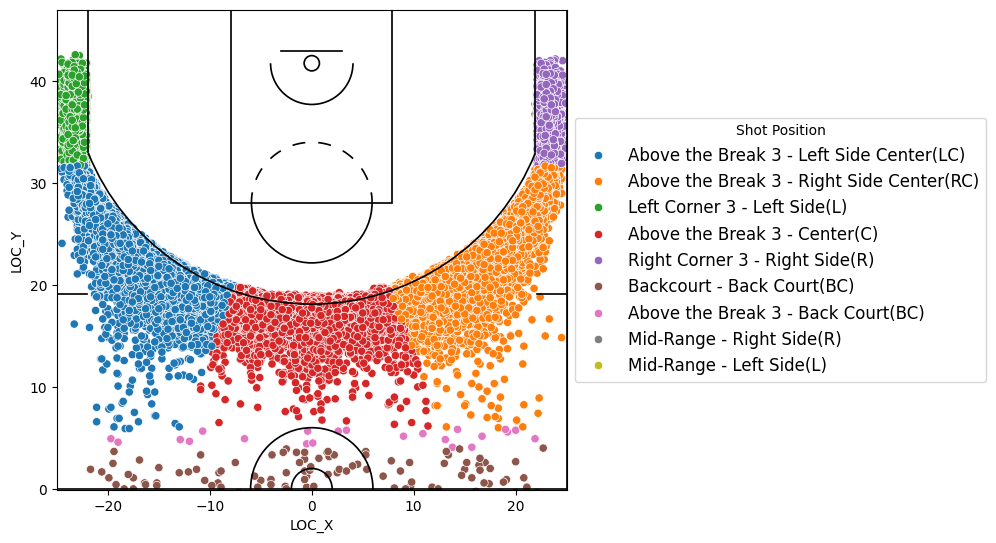

In [7]:
# Create figure and axes
fig = plt.figure()
ax = fig.add_axes(rect=[0, 0, 1, 1])

# Colour each shot based on its position
shot_chart = sns.scatterplot(data=df, x='LOC_X', y='LOC_Y', hue='SHOT_POSITION', ax=ax)
shot_chart.legend(title='Shot Position', loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})

# Draw court lines on top of scatterplot
court = Court(court_type='nba', origin='center', units='ft')
court.draw(ax=ax, orientation='vu', showaxis=True, pad=0)

plt.show()

In [8]:
# Check how the shot result is categorised
df['SHOT_MADE_FLAG'].value_counts(normalize=True)

SHOT_MADE_FLAG
0    0.641233
1    0.358767
Name: proportion, dtype: float64

In [9]:
# Check number of shots beyond "Starry shot" distance (30ft)
distance_starry = 30
df.loc[df['SHOT_DISTANCE'] >= distance_starry, 'SHOT_POSITION'].value_counts()

SHOT_POSITION
Above the Break 3 - Left Side Center(LC)     532
Above the Break 3 - Center(C)                521
Above the Break 3 - Right Side Center(RC)    421
Backcourt - Back Court(BC)                   350
Above the Break 3 - Back Court(BC)            23
Name: count, dtype: int64

## Data Processing
The steps listed below will be followed to simulate the 3-point contest. This section will cover steps 1-3.
1. Define the 7 shot positions in the 3-point contest based on the existing data. This will involve creating 2 new categorisations for the Starry shots (left side and right side).
2. Calculate the league's average shot percentages from each of the 7 shot positions in the 3-point contest. If a contestant has not shot from a 3-point contest position, the missing data is filled in with a random percentage that is at most the league's average from that position.
3. For each player in the contest, calculate their shooting efficiencies from each of the 7 shot positions in the 3-point contest. 
4. Use the calculated efficiency for each location to simulate whether the shot is made or missed.
5. Visualise the simulation on a plot.

### Selection of Shot Zones
To calculate the shot percentages for Starry shots, all shots in the range 30-33ft will be considered. Starry shots will be now categorised as either left or right based on the X-coordinate.

In [10]:
# Define Starry shots
is_starry_range = (df['SHOT_DISTANCE'] >= distance_starry) & (df['SHOT_DISTANCE'] <= distance_starry+3)
is_starry_left_x = (df['LOC_X'] >= -15) & (df['LOC_X'] < -5)
is_starry_right_x = (df['LOC_X'] >= 5) & (df['LOC_X'] <= 15)
df.loc[is_starry_range & is_starry_left_x, 'SHOT_POSITION'] = 'Starry 3 - Left'
df.loc[is_starry_range & is_starry_right_x, 'SHOT_POSITION'] = 'Starry 3 - Right'

df.loc[is_starry_range, 'SHOT_POSITION'].value_counts()

SHOT_POSITION
Starry 3 - Left                              293
Starry 3 - Right                             263
Above the Break 3 - Left Side Center(LC)     251
Above the Break 3 - Center(C)                243
Above the Break 3 - Right Side Center(RC)    201
Name: count, dtype: int64

In [11]:
# Keep only shots from the 7 contest positions
positions_contest = [
    'Left Corner 3 - Left Side(L)',
    'Above the Break 3 - Left Side Center(LC)',
    'Starry 3 - Left',
    'Above the Break 3 - Center(C)',
    'Starry 3 - Right',
    'Above the Break 3 - Right Side Center(RC)',
    'Right Corner 3 - Right Side(R)'
]

df = df[df['SHOT_POSITION'].isin(positions_contest)]

# Keep only shot from Starry positions or from rack positions
# if they are shot below Starry distance
is_starry = df['SHOT_POSITION'].str.split(' - ').str[0] == 'Starry 3'
df = df[is_starry | (df['SHOT_DISTANCE'] < distance_starry)]

df['SHOT_POSITION'].value_counts()

SHOT_POSITION
Above the Break 3 - Left Side Center(LC)     17066
Above the Break 3 - Right Side Center(RC)    15836
Above the Break 3 - Center(C)                10766
Left Corner 3 - Left Side(L)                  7953
Right Corner 3 - Right Side(R)                7499
Starry 3 - Left                                293
Starry 3 - Right                               263
Name: count, dtype: int64

The plot below shows all the shots that haven taken from positions similar to the 7 positions in the contest.

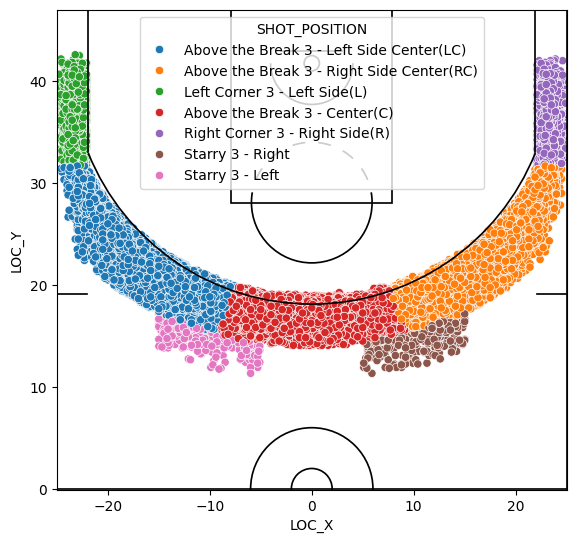

In [12]:
# Create a figure with axes
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])

# Plot shots
sns.scatterplot(data=df, x='LOC_X', y='LOC_Y', hue='SHOT_POSITION', ax=ax)

# Draw court lines on top of scatterplot
court = Court(court_type='nba', origin='center', units='ft')
court.draw(ax=ax, orientation='vu', showaxis=True, pad=0)
plt.show()

### Average Shot Percentage by Position
If a contestant has not shot from a 3-point contest position, the missing data will be filled in with at most the league's average from that position.

In [13]:
avg_shot_percentage_by_position = df.groupby('SHOT_POSITION')['SHOT_MADE_FLAG'].mean()
avg_shot_percentage_by_position

SHOT_POSITION
Above the Break 3 - Center(C)                0.353892
Above the Break 3 - Left Side Center(LC)     0.357612
Above the Break 3 - Right Side Center(RC)    0.354004
Left Corner 3 - Left Side(L)                 0.382371
Right Corner 3 - Right Side(R)               0.388852
Starry 3 - Left                              0.276451
Starry 3 - Right                             0.277567
Name: SHOT_MADE_FLAG, dtype: float64

### Calculation of Contestants' Shot Percentages
Now that we are able to filter the 3-point shots correctly, let's apply it on the contestants' shots and calculate the shot percentage from each position.

In [14]:
contestants = [
    'Jalen Brunson', 'Cade Cunningham', 'Darius Garland', 'Tyler Herro',
    'Buddy Hield', 'Cameron Johnson', 'Damian Lillard', 'Norman Powell'
]

df = df[df['PLAYER_NAME'].isin(contestants)]
df = df.groupby(['PLAYER_NAME', 'SHOT_POSITION'])['SHOT_MADE_FLAG'].mean().reset_index()
df = df.rename(columns={'SHOT_MADE_FLAG': 'SHOT_PERCENTAGE'})
df.head(14)

,PLAYER_NAME,SHOT_POSITION,SHOT_PERCENTAGE
0,Buddy Hield,Above the Break 3 - Center(C),0.350877
1,Buddy Hield,Above the Break 3 - Left Side Center(LC),0.350365
2,Buddy Hield,Above the Break 3 - Right Side Center(RC),0.371134
3,Buddy Hield,Left Corner 3 - Left Side(L),0.354167
4,Buddy Hield,Right Corner 3 - Right Side(R),0.447368
5,Buddy Hield,Starry 3 - Left,0.000000
6,Buddy Hield,Starry 3 - Right,1.000000
7,Cade Cunningham,Above the Break 3 - Center(C),0.372340
8,Cade Cunningham,Above the Break 3 - Left Side Center(LC),0.364486
9,Cade Cunningham,Above the Break 3 - Right Side Center(RC),0.333333


In [15]:
# For each player that is missing shot percentages, identify the zones from which they have not shot during the regular season
num_positions_by_player = df['PLAYER_NAME'].value_counts()
players_with_missing_positions = num_positions_by_player[num_positions_by_player < len(positions_contest)].keys()

for player_name in players_with_missing_positions:
    positions_player = df.loc[df['PLAYER_NAME'] == player_name, 'SHOT_POSITION']
    missing_positions = set(positions_contest) - set(positions_player)

    # Populate the missing zones' shooting percentages with a value that
    # is at most the league's average percentage from that position
    for shot_position in missing_positions:
        df.loc[len(df)] = [
            player_name,
            shot_position,
            random.random() * avg_shot_percentage_by_position[shot_position]
        ]

df['PLAYER_NAME'].value_counts()

PLAYER_NAME
Buddy Hield        7
Cade Cunningham    7
Cameron Johnson    7
Damian Lillard     7
Darius Garland     7
Jalen Brunson      7
Norman Powell      7
Tyler Herro        7
Name: count, dtype: int64

## Simulation (Single Round)
Once all players' shooting percentages from the 7 contest positions have been calculated, it is time to run the simulation.

In [16]:
# Create dictionary to keep track of the shots made by 
# each contestant, the position of the shots and the
# maximum amount of contest points possible after each shot
contest_summary = {}

shot_order = [
    'Left Corner 3 - Left Side(L)',
    'Above the Break 3 - Left Side Center(LC)',
    'Starry 3 - Left',
    'Above the Break 3 - Center(C)',
    'Starry 3 - Right',
    'Above the Break 3 - Right Side Center(RC)',
    'Right Corner 3 - Right Side(R)'
]

for player in df['PLAYER_NAME'].unique():
    # Initialise player's contest summary
    if player not in contest_summary:
        contest_summary[player] = {
            'Points': [],
            'Shot Positions': [],
            'Maximum Points Possible': []
        }

    print(f'{player:-^60}')

    # Use only current player's percentages
    df_current_player_percentages = df.loc[df['PLAYER_NAME'] == player]

    # Place money rack in position where player has the higher percentage
    is_rack_position = df_current_player_percentages['SHOT_POSITION'].str.split(' - ').str[0] != 'Starry 3'
    df_player_racks = df_current_player_percentages[is_rack_position]
    is_max_percentage = df_player_racks['SHOT_PERCENTAGE'].idxmax()
    money_rack = df_player_racks.loc[is_max_percentage, 'SHOT_POSITION']

    # Create variables keep track of the player's score and the
    # maximum amount of points the player could have after each shot
    player_score = 0
    max_points_possible = 0

    # "Start shooting"
    for position in shot_order:
        percentage_from_position = df_current_player_percentages.loc[df_current_player_percentages['SHOT_POSITION'] == position, 'SHOT_PERCENTAGE'].values[0]
        shots_from_position = 0

        # Starry shots (worth 3 points)
        if position.split(' - ')[0] == 'Starry 3':
            # Determine whether shot is made or missed
            shot_made = random.random() <= percentage_from_position
            shot_value = int(shot_made) * 3

            # Update score and maximum points possible
            player_score += shot_value
            max_points_possible += 3

            # Store state of the player's contest
            contest_summary[player]['Shot Positions'].append(position)
            contest_summary[player]['Points'].append(player_score)
            contest_summary[player]['Maximum Points Possible'].append(max_points_possible)
            
            # Print player's state of the contest
            print(f'{position} #{shots_from_position+1} ({'MAKE!' if shot_made else 'MISS!'}) - {contest_summary[player]['Points'][-1]}/{max_points_possible}')

        # Racks
        else:
            while shots_from_position < 5:
                # Determine whether shot is made or missed
                shot_made = random.random() <= percentage_from_position
                shot_value = int(shot_made) # 1 if made, 0 if missed

                # If shot is part of the money rack or if it is a colour ball,
                # the value of the shot is double
                if position == money_rack or shots_from_position == 4:
                    shot_value *= 2
                    max_points_possible += 2
                else:
                    max_points_possible += 1

                player_score += shot_value
                shots_from_position += 1

                # Store state of the player's contest
                contest_summary[player]['Shot Positions'].append(position)
                contest_summary[player]['Points'].append(player_score)
                contest_summary[player]['Maximum Points Possible'].append(max_points_possible)

                print(f'{position} #{shots_from_position} -> {'MAKE!' if shot_made else 'MISS!'} -> {contest_summary[player]['Points'][-1]}/{max_points_possible}')

    print()

------------------------Buddy Hield-------------------------
Left Corner 3 - Left Side(L) #1 -> MISS! -> 0/1
Left Corner 3 - Left Side(L) #2 -> MISS! -> 0/2
Left Corner 3 - Left Side(L) #3 -> MISS! -> 0/3
Left Corner 3 - Left Side(L) #4 -> MISS! -> 0/4
Left Corner 3 - Left Side(L) #5 -> MISS! -> 0/6
Above the Break 3 - Left Side Center(LC) #1 -> MAKE! -> 1/7
Above the Break 3 - Left Side Center(LC) #2 -> MISS! -> 1/8
Above the Break 3 - Left Side Center(LC) #3 -> MISS! -> 1/9
Above the Break 3 - Left Side Center(LC) #4 -> MISS! -> 1/10
Above the Break 3 - Left Side Center(LC) #5 -> MAKE! -> 3/12
Starry 3 - Left #1 (MISS!) - 3/15
Above the Break 3 - Center(C) #1 -> MISS! -> 3/16
Above the Break 3 - Center(C) #2 -> MAKE! -> 4/17
Above the Break 3 - Center(C) #3 -> MISS! -> 4/18
Above the Break 3 - Center(C) #4 -> MAKE! -> 5/19
Above the Break 3 - Center(C) #5 -> MISS! -> 5/21
Starry 3 - Right #1 (MAKE!) - 8/24
Above the Break 3 - Right Side Center(RC) #1 -> MAKE! -> 9/25
Above the Break 

## Plotting the Contest
Each player's contest results have been stored in the `contest_summary` dictionary. Let's use this to visualise the contest results on the court!

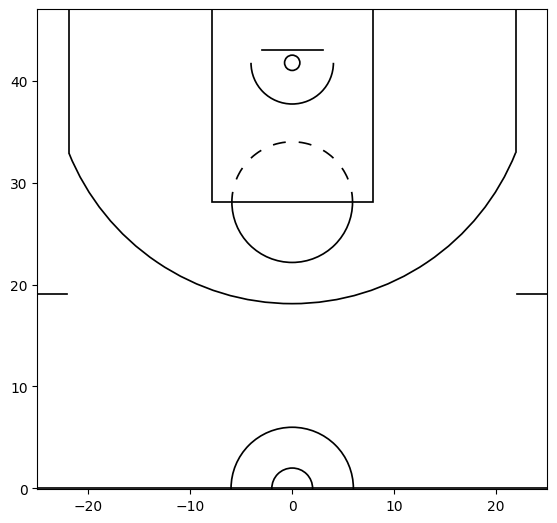

In [17]:
# Plot a blank court
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# Draw court lines on top of scatterplot
court = Court(court_type='nba', origin='center', units='ft')
court.draw(ax=ax, orientation='vu', showaxis=True, pad=0)
plt.show()

In [18]:
# Coordinates in which to plot the first shot from each position
initial_plot_coordinates = {
    'Left Corner 3 - Left Side(L)': (-23.5,42),
    'Above the Break 3 - Left Side Center(LC)': (-15.5,22.5),
    'Starry 3 - Left': (-7.5, 15),
    'Above the Break 3 - Center(C)': (0,17),
    'Starry 3 - Right': (7.5, 15),
    'Above the Break 3 - Right Side Center(RC)': (15.5,22.5),
    'Right Corner 3 - Right Side(R)': (23.5,42)
}

The animation for the contest simulation updates after each shot. The `initial_plot_coordinates` dictionary determines the coordinates in which to plot the first shot from each position. However, there are 5 shots in each rack and shots 2-5 need to be plotted just next to their preceding shot. Therefore it is important to know how many shots have been shot in that position already and create this space accordingly. This is what the `get_num_shots_from_current_position` function does.

In [19]:
def get_num_previous_shots_from_current_position(num_total_shots):
    """
    Calculate how many shots have been shot from the
    current rack position prior to the current shot

    :param num_total_shots: Total shots the player has shot in the contest
    :type num_total_shots: int
    :return: Number of shots the player has shot from the current position
    :rtype: int
    """

    # "Starry" shot: only one shot in each "Starry" position,
    # so no prior shot can have been taken from "Starry" position
    if num_total_shots in {11,17}:
        return 0
    
    # After second "Starry shot" (18 <= num_total_shots <= 27)
    # Centre shots (12 <= num_total_shots <= 16)
    # Shots prior to first "Starry" shot (1 <= num_total_shots <= 10)
    for n in [18,12,1]:
        if num_total_shots >= n:
            return (num_total_shots - n) % 5

Let's plot the entire contest in a single animation, where each player's animation is placed side-by-side.

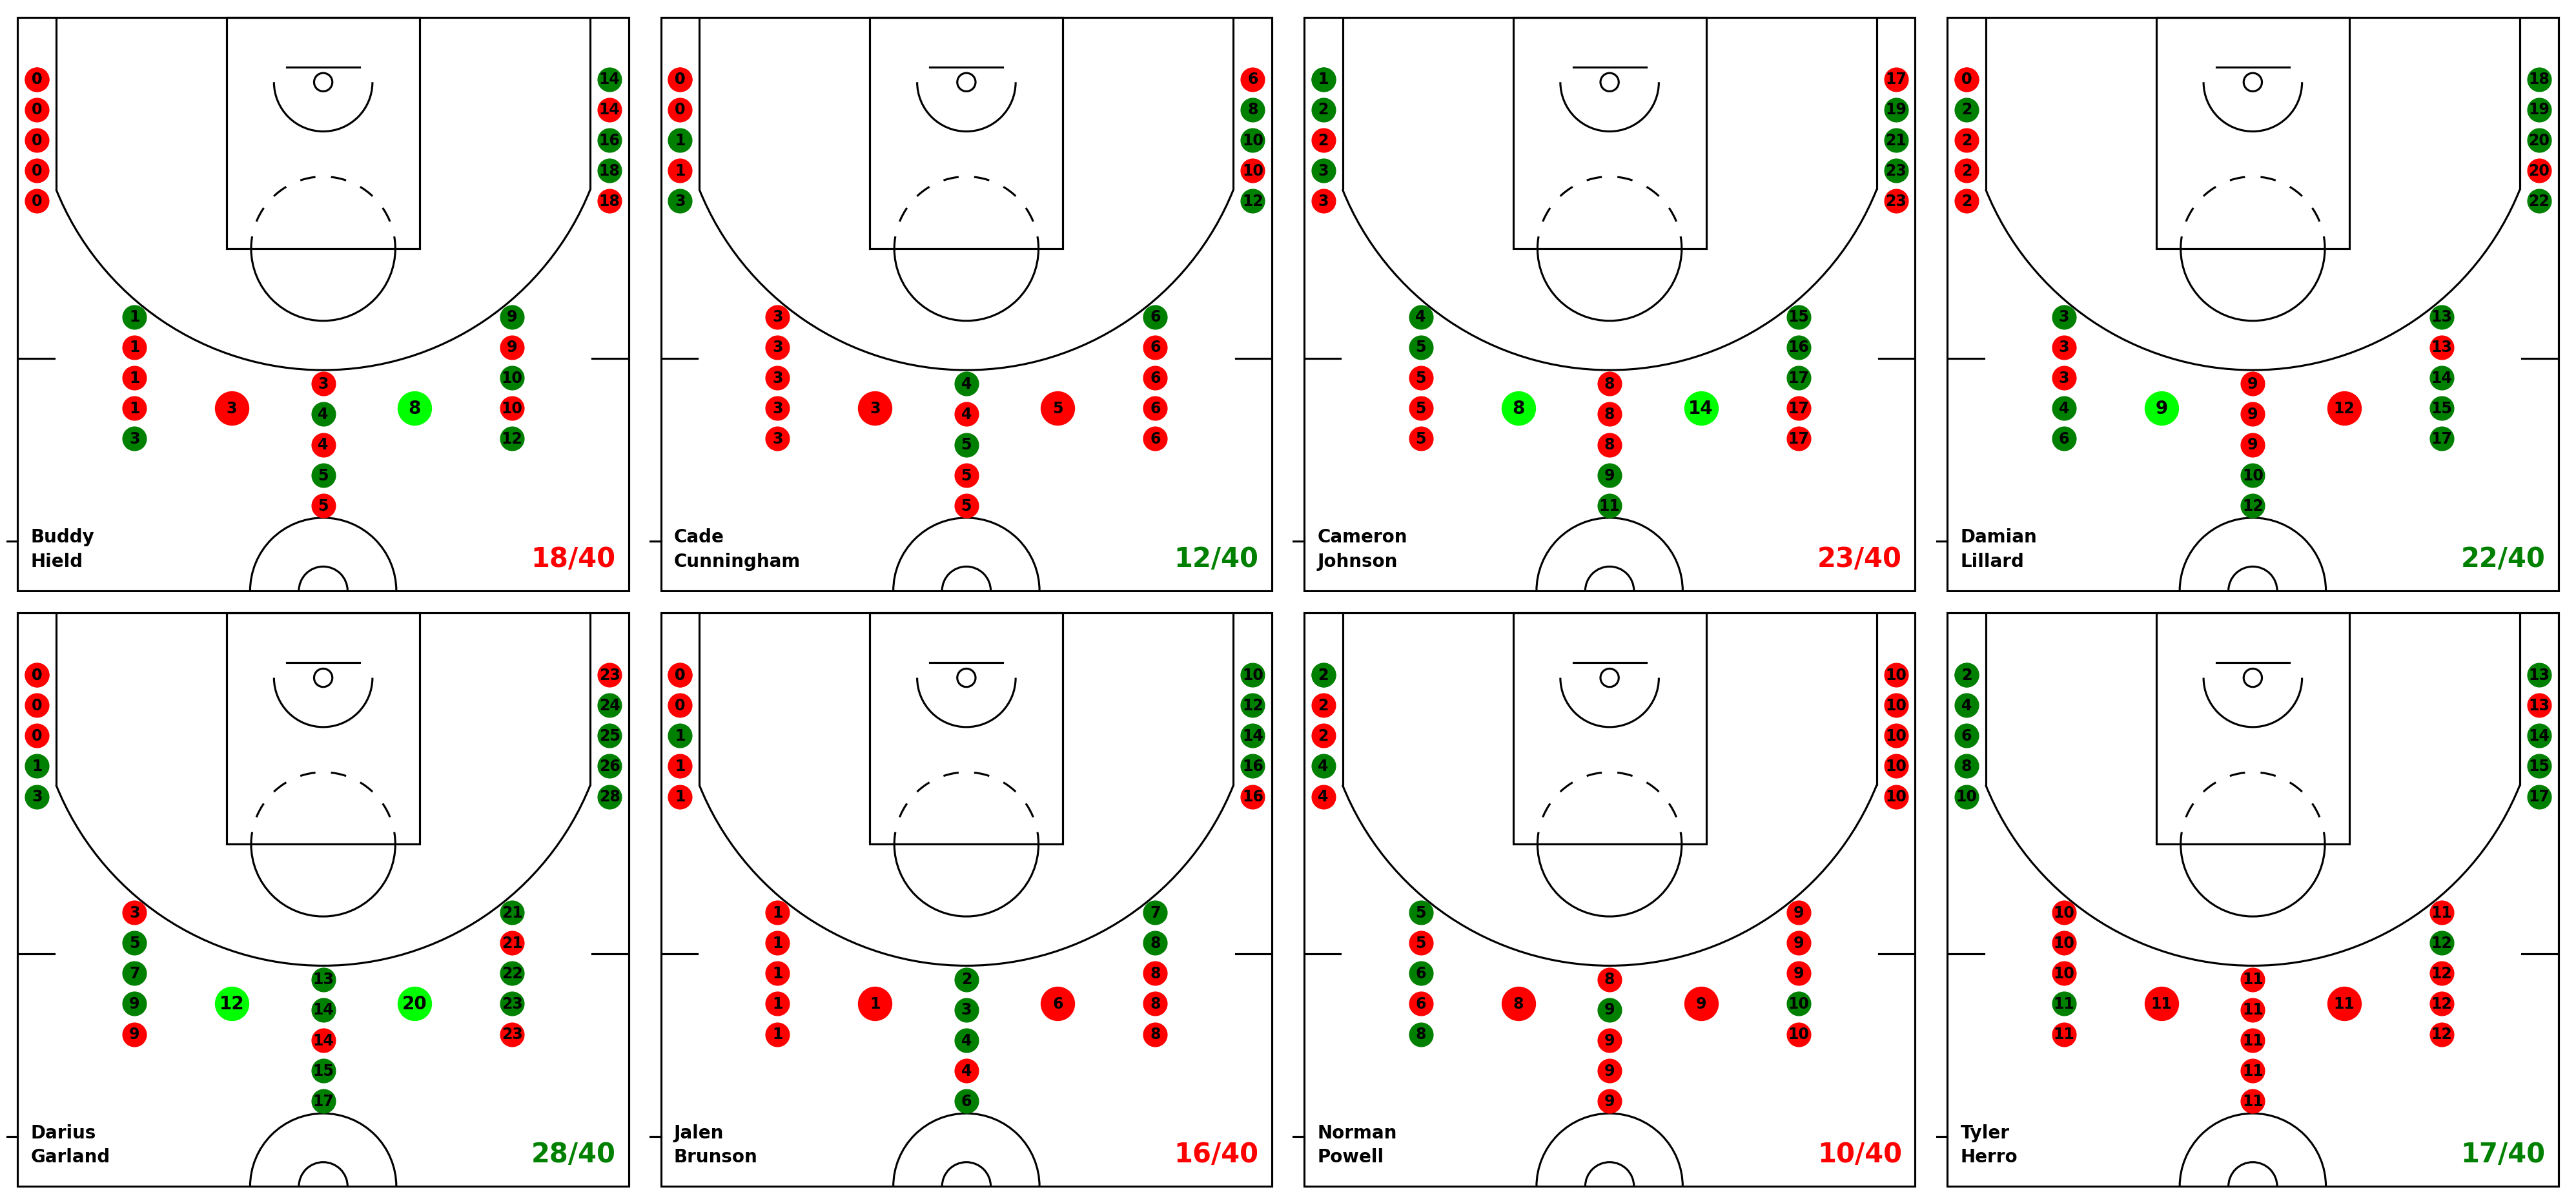

In [20]:
# Create a figure with subplots for each player
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))
axes = axes.flatten()
# Draw the court on each subplot
court = Court(court_type='nba', origin='center', units='ft')
for ax in axes:
    court.draw(ax=ax, orientation='vu', pad=1)

# Dictionary to store text objects that are removed after each frame update
text_objects = {}

# Function to update the plot for each frame
def update_plot(shot_number):
    '''
    Update plot one shot at a time

    :param shot_number: Number of shot to plot in the visualisation
    :type shot_number: int
    :return: None
    '''    

    # For each player
    for i, player in enumerate(contest_summary.keys()):
        # Determine coordinates for plotting shot
        shot_position = contest_summary[player]['Shot Positions'][shot_number-1]
        x, y = initial_plot_coordinates[shot_position]
        num_shots_from_position = get_num_previous_shots_from_current_position(num_total_shots=shot_number)
        y -= num_shots_from_position * 2.5

        # Determine whether shot is made or missed
        current_score = contest_summary[player]['Points'][shot_number-1]
        shot_made = current_score > 0 if shot_number == 1 else current_score > contest_summary[player]['Points'][shot_number-2]
        max_points_possible = contest_summary[player]['Maximum Points Possible'][shot_number-1]

        # Determine ball colour
        if shot_made:
            if shot_number in {11,17}:  # "Starry" shot
                ball_colour = 'lime'
            else:
                ball_colour = 'green'
        else:
            ball_colour = 'red'

        # Plot ball and add text with current score
        axes[i].scatter(x=x, y=y, s=1400 if shot_number in {11,17} else 700, color=ball_colour)
        axes[i].annotate(
            text=current_score,
            xy=(x,y),
            size=20 if ball_colour == 'lime' else 17,
            fontweight='bold',
            ha='center',
            va='center'
        )

        # Remove the old text from the plot if it exists
        for idx in [i, i+0.1, i+0.2]:
            if idx in text_objects:
                text_objects[idx].remove()
        
        # Add new text for the player's first name
        text_objects[i] = axes[i].text(
            x=-24,
            y=4,
            s=player.split(' ')[0],
            fontsize=20,
            fontweight='bold',
            ha='left'
        )

        # Add new text for the player's surname
        text_objects[i+0.1] = axes[i].text(
            x=-24,
            y=2,
            s=' '.join(player.split(' ')[1:]),
            fontsize=20,
            fontweight='bold',
            ha='left'
        )

        # Add new text for the player's current score
        text_objects[i+0.2] = axes[i].text(
            x=24,
            y=2,
            s=f'{current_score}/{max_points_possible}',
            color='green' if shot_made else 'red',
            fontsize=30,
            fontweight='bold',
            ha='right'
        )

        # Adjust spacing
        plt.tight_layout()

# Create the animation
ani = animation.FuncAnimation(fig=fig, func=update_plot, frames=range(1, 28), interval=25, repeat=False)
ani.save(filename='animation_contest.gif', writer='pillow', fps=3)
# Display the animation
plt.show()